In [89]:
import pandas as pd
import numpy as np
import glob
import os
import sklearn
import sys
import datetime
import xgboost as xgb
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)

In [90]:
test_pitch=pd.read_csv('test_pitch.csv')
test_player=pd.read_csv('test_player.csv')
train_pitch=pd.read_csv('train_pitch.csv')
train_player=pd.read_csv('train_player.csv')

# train merge

In [77]:
train_player_kari=train_player.loc[:, [ '選手ID', '位置', '投', '社会人', 'ドラフト順位', '年俸', '出身国']]

In [80]:
train_pitcher_kari=train_player_kari[train_player_kari['位置']=='投手']

In [94]:
train_pitcher_kari=train_pitcher_kari.rename(columns={'選手ID':'投手ID'})

In [95]:
train_merge=pd.merge(train_pitch, train_pitcher_kari, on='投手ID')

# ピッチャーを抜き出す

In [105]:
pitcher1=train_player[train_player['位置'] =='投手']
pitcher2=test_player[test_player['位置']=='投手']
pitcher3=pd.concat([pitcher1, pitcher2])

In [106]:
pitcher4=pitcher3.groupby('選手ID').mean()
pitcher5=pitcher4.iloc[:, [4, 5]]
X=pitcher5.values

In [107]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=5,
          init='k-means++',
          n_init=5,
          max_iter=300,
          tol=1e-04,
          random_state=0)
y_km=km.fit_predict(X)

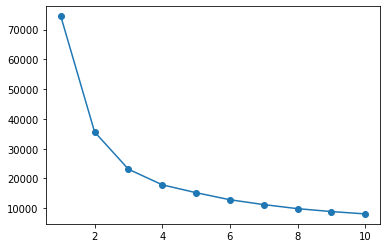

In [108]:
import matplotlib.pyplot as plt
distortions=[]
for i in range(1, 11):
    km=KMeans(n_clusters=i,
          init='k-means++',
          n_init=10,
          max_iter=300,
          random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')

In [109]:
ID=pitcher5.index
dic={}
for k, n in zip(y_km, ID):
    dic[n] = k

# 捕手抜き出し

In [110]:
hosyu1=train_player[train_player['位置'] =='捕手']
hosyu2=test_player[test_player['位置']=='捕手']
hosyu3=pd.concat([hosyu1, hosyu2])
hosyu4=hosyu3.groupby('選手ID').mean()
hosyu5=hosyu4.iloc[:, [4, 5]]
X1=hosyu5.values

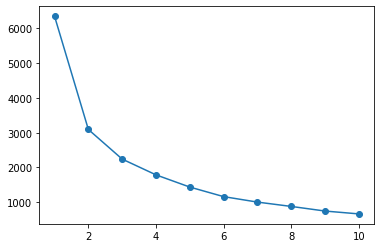

In [111]:
import matplotlib.pyplot as plt
distortions=[]
for i in range(1, 11):
    km=KMeans(n_clusters=i,
          init='k-means++',
          n_init=10,
          max_iter=300,
          random_state=0)
    km.fit(X1)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 11), distortions, marker='o')

In [112]:
from sklearn.cluster import KMeans
km=KMeans(n_clusters=5,
          init='k-means++',
          n_init=5,
          max_iter=300,
          tol=1e-04,
          random_state=0)
y_km=km.fit_predict(X1)

In [113]:
IDh=hosyu5.index
dic1={}
for k, n in zip(y_km, IDh):
    dic1[n] = k

In [116]:
train_merge['投手ID']=train_merge['投手ID'].apply(lambda x:dic[x])
train_merge['捕手ID']=train_merge['捕手ID'].apply(lambda x:dic1[x])

In [115]:
dic1[600020]=1

In [40]:
test_pitch['捕手ID']=test_pitch['捕手ID'].apply(lambda x:dic1[x])
test_pitch['投手ID']=test_pitch['投手ID'].apply(lambda x:dic[x])

# データをいじる

In [117]:
train_merge.columns

Index(['Unnamed: 0', 'データ内連番', '球種', '年度', '試合ID', '試合内連番', '試合内投球数', '日付',
       '時刻', 'ホームチームID', 'アウェイチームID', '球場ID', '球場名', '試合種別詳細', 'イニング', '表裏',
       'イニング内打席数', '打席内投球数', '投手ID', '投手チームID', '投手投球左右', '投手役割', '投手登板順',
       '投手試合内対戦打者数', '投手試合内投球数', '投手イニング内投球数', '打者ID', '打者チームID', '打者打席左右',
       '打者打順', '打者守備位置', '打者試合内打席数', 'プレイ前ホームチーム得点数', 'プレイ前アウェイチーム得点数',
       'プレイ前アウト数', 'プレイ前ボール数', 'プレイ前ストライク数', 'プレイ前走者状況', '一塁走者ID', '二塁走者ID',
       '三塁走者ID', '捕手ID', '一塁手ID', '二塁手ID', '三塁手ID', '遊撃手ID', '左翼手ID', '中堅手ID',
       '右翼手ID', '成績対象投手ID', '成績対象打者ID', '位置', '投', '社会人', 'ドラフト順位', '年俸',
       '出身国'],
      dtype='object')

In [123]:
train_kari=train_merge.loc[:, ['試合内投球数', 'イニング', '表裏', 'イニング内打席数', '打席内投球数', '投手ID','投手投球左右', '投手役割', '投手試合内対戦打者数', '投手試合内投球数', '投手イニング内投球数','打者打席左右', 
                           '打者打順', 'プレイ前ホームチーム得点数', 'プレイ前アウェイチーム得点数', 
                           'プレイ前アウト数', 'プレイ前ボール数', 'プレイ前ストライク数', 'プレイ前走者状況','捕手ID', 
                               '投', 'ドラフト順位', '年俸',
                               '出身国']]

In [124]:
train=pd.get_dummies(train_kari, columns=["表裏", "投手ID", "投手投球左右", "投手役割", "打者打席左右", "プレイ前走者状況", "捕手ID", '投', 'ドラフト順位',
                               '出身国'])

In [ ]:
test_kari=test_pitch.loc[:, ['試合内投球数', 'イニング', '表裏', 'イニング内打席数', '打席内投球数', '投手ID','投手投球左右', '投手役割', '投手試合内対戦打者数', '投手試合内投球数', '投手イニング内投球数','打者打席左右', 
                           '打者打順', 'プレイ前ホームチーム得点数', 'プレイ前アウェイチーム得点数', 
                           'プレイ前アウト数', 'プレイ前ボール数', 'プレイ前ストライク数', 'プレイ前走者状況','捕手ID', 
                               '投', '社会人', 'ドラフト順位', '年俸',
                               '出身国']]

In [45]:
test=pd.get_dummies(test_kari, columns=["表裏", "投手ID", "投手投球左右", "投手役割", "打者打席左右", "プレイ前走者状況", "捕手ID"])

In [120]:
y=train_merge['球種']

In [47]:
test.shape

(521650, 39)

In [126]:
train

,試合内投球数,イニング,イニング内打席数,打席内投球数,投手試合内対戦打者数,投手試合内投球数,投手イニング内投球数,打者打順,プレイ前ホームチーム得点数,プレイ前アウェイチーム得点数,プレイ前アウト数,プレイ前ボール数,プレイ前ストライク数,年俸,表裏_表,表裏_裏,投手ID_0,投手ID_1,投手ID_2,投手ID_3,投手ID_4,投手投球左右_右,投手投球左右_左,投手役割_先発,投手役割_救援,打者打席左右_右,打者打席左右_左,プレイ前走者状況_123,プレイ前走者状況_12_,プレイ前走者状況_1_3,プレイ前走者状況_1__,プレイ前走者状況__23,プレイ前走者状況__2_,プレイ前走者状況___3,プレイ前走者状況____,捕手ID_0,捕手ID_1,捕手ID_2,捕手ID_3,捕手ID_4,投_右,投_左,ドラフト順位_1.0,ドラフト順位_2.0,ドラフト順位_3.0,ドラフト順位_4.0,ドラフト順位_5.0,ドラフト順位_6.0,ドラフト順位_7.0,ドラフト順位_8.0,ドラフト順位_9.0,出身国_アメリカ,出身国_オランダ,出身国_カナダ,出身国_キューバ,出身国_タイ,出身国_ドミニカ共和国,出身国_ブラジル,出身国_ベネズエラ,出身国_メキシコ,出身国_台湾,出身国_日本
0,1,1,1,1,1,1,1,1,0,0,0,0,0,24000,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1,1,2,1,2,2,1,0,0,0,0,1,24000,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,1,1,3,1,3,3,1,0,0,0,0,2,24000,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,4,1,2,1,2,4,4,2,0,0,1,0,0,24000,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1,2,2,2,5,5,2,0,0,1,0,1,24000,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257112,253,8,1,5,1,5,5,8,6,0,0,0,2,8800,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
257113,254,8,1,6,1,6,6,8,6,0,0,0,2,8800,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
257114,255,8,2,1,2,7,7,9,6,1,0,0,0,8800,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
257115,256,8,2,2,2,8,8,9,6,1,0,0,1,8800,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [127]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=1)

In [128]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(max_depth=15, max_features=10, n_estimators=300, random_state=1)

In [129]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features=10, n_estimators=300,
                       random_state=1)

In [130]:
from sklearn.metrics import log_loss

In [62]:
a=train.columns

In [63]:
b=rf.feature_importances_

In [64]:
dic={}
for i, k in zip(a, b):
    dic[i]=k

In [73]:
dic

{'試合内投球数': 0.11701763960811488,
 'イニング': 0.038397243134172636,
 'イニング内打席数': 0.03584987987689145,
 '打席内投球数': 0.045739789575198864,
 '投手試合内対戦打者数': 0.055586407601177716,
 '投手試合内投球数': 0.0918241749744775,
 '投手イニング内投球数': 0.07338858212818468,
 '打者打順': 0.051691918037370395,
 'プレイ前ホームチーム得点数': 0.049885836928137244,
 'プレイ前アウェイチーム得点数': 0.05278322426354236,
 'プレイ前アウト数': 0.020646147691003452,
 'プレイ前ボール数': 0.037011837322970226,
 'プレイ前ストライク数': 0.03368613174874585,
 '表裏_表': 0.013108876589533046,
 '表裏_裏': 0.01318193954543642,
 '投手ID_0': 0.013066791213024424,
 '投手ID_1': 0.01729011686668153,
 '投手ID_2': 0.013830786319169182,
 '投手ID_3': 0.012449325582315141,
 '投手ID_4': 0.014333400246582074,
 '投手投球左右_右': 0.009264174449975994,
 '投手投球左右_左': 0.009062672740941557,
 '投手役割_先発': 0.005503602858468964,
 '投手役割_救援': 0.005230748002023235,
 '打者打席左右_右': 0.014637255246010616,
 '打者打席左右_左': 0.014474119900661967,
 'プレイ前走者状況_123': 0.0040015500822028535,
 'プレイ前走者状況_12_': 0.00813437181816622,
 'プレイ前走者状況_1_3': 0.00530923502367268

In [132]:
y_proba=rf.predict_proba(X_test)

In [54]:
result=pd.DataFrame(y_proba)

In [55]:
result.to_csv('result.csv')

In [133]:
log_loss(y_test, y_proba, eps=1e-15, normalize=True, sample_weight=None, labels=None)

1.270242149361549

In [26]:
search_params = {
     'n_estimators'      : [5, 10, 20, 30, 50, 100, 300],
      'max_features'      : [3, 5, 10, 15, 20],
      'random_state'      : [1],
      'max_depth'         : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
}

In [24]:
from sklearn.model_selection import GridSearchCV

In [27]:
gs = GridSearchCV(rf,           # 対象の機械学習モデル
                  search_params,   # 探索パラメタ辞書
                  cv=3,            # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)       # 並列処理
gs.fit(X_train, y_train)
 
print(gs.best_estimator_)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 138.1min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 228.7min finished


RandomForestClassifier(max_depth=15, max_features=10, n_estimators=300,
                       random_state=1)
